In [2]:
import urllib3, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import random, randint

In [2]:
http = urllib3.PoolManager()

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def namefromaddr(addr):
    addr = addr[addr.find('.ru/')+4 : addr.rfind('/')]
    return addr[:addr.find('/')], addr[addr.find('/')+1:]

In [204]:
data = pd.DataFrame(columns = ['num', 'maker', 'model', 'head', 'price', 'engine', 'power',
                              'gears', 'drive', 'body', 'color', 'mile', 'wheel', 'notes',
                               'gen', 'trim', 'exch', 'descr', 'card'])

In [167]:
def clean(s):
    return s[s.rfind('>') + 1 : -1]

head = re.compile('''n0">Продажа (.*?)<''')
price = re.compile('''1hu13v1 e162wx9x0">(.*?)<''')
eng = re.compile('''fvoogh e162wx9x0">(.*?)<''')
hp = re.compile('''css-1v24z2u e1wvjnck0">(.*?)<''')
trans = re.compile("миссия</th><td colSpan=\"1\" class=\"css-1uz0iw8 ezjvm5n1\">(.*?)\<")
wd = re.compile('''вод</th><td colSpan="1" class="css-1uz0iw8 ezjvm5n1">(.*?)<''')
body = re.compile('''зова</th><td colSpan="1" class="css-1uz0iw8 ezjvm5n1">(.*?)<''')
clr = re.compile( '''вет</th><td colSpan="1" class="css-1uz0iw8 ezjvm5n1">(.*?)<''' )
mile = re.compile('''км</th><td colSpan="1" class="css-1uz0iw8 ezjvm5n1">(.*?)<''')
mile_ = re.compile('''бег</th''')
wheel = re.compile('''уль</th><td colSpan="1" class="css-1uz0iw8 ezjvm5n1">(.*?)<''')
notes = re.compile('''1"><span class="css-fvoogh e162wx9x0">(.*?)<''')
gen = re.compile('''ние</th><td colSpan="1" class="css-1uz0iw8 ezjvm5n1">"(.*?)<''')
gen_ = re.compile('''generation_link" data-ga-stats-track-click="true" class="css-ypktkp e1oy5ngb0">(.*?)\<''')
comp = re.compile('''complectation_link" data-ga-stats-track-click="true" class="css-ypktkp e1oy5ngb0">(.*?)\<''')
exch = re.compile('''мен<!-- -->: </span><span class="css-11eoza4 e162wx9x0">(.*?)<''')
dscr = re.compile('''ьно<!-- -->: </span><span class="css-11eoza4 e162wx9x0">(.*?)</''', re.DOTALL)
card = re.compile('''ru/\S{1,50}/" class="css-ioq5yh e1wvjnck0">(.*?)<''')

params = [eng, hp, trans, wd, body, clr, mile, wheel, notes, comp, exch]
names = ['head', 'price', 'engine', 'power', 'gears', 'drive', 'body', 'color', 'mile', 'wheel', 'notes', 'trim', 'exch']

def parse(html):
    
    out = {}
    for entry in zip(names[:2], [head, price]): ########## head and price
        hds = clean( re.search(entry[1], html)[0] )
        #print(entry[0], hds, sep = ': ')
        out[entry[0]] = hds
    for en in zip(names[2:], params): ################### other entries
        ent = re.search(en[1], html)
        if ent:
            ent = clean(ent[0])
        else:
            ent = ''
        #print(en[0], ent, sep=': ')
        out[en[0]] = ent
    if re.search(mile, html):
        if out['mile']: print('something wrong: ', out['mile'], ' km')
        out['mile'] = '0'
    dsc = re.search(dscr, html) ############################## descr
    if dsc: 
        dsc = dsc[0][56: -2]
        dsc = re.sub( '''<br(\s.)?>'''  , ' ', re.sub('''[\r\n]''','',dsc))
    else: dsc = ''
    out['descr'] = dsc
    gen_1 = re.search(gen, html) ######################### generation
    res = None
    if gen_1:
        res = clean(gen_1[0])
    else:
        gen_2 = re.search(gen, html)
        if gen_2:
            res = clean(gen_2[0])
        else:
            res = ''
    out['gen'] = res
    #print('gen', res, sep=': ')
    car = re.search(card, html) ############################# dealer card
    if car:
        car = car[0]
        id_br = car.rfind('>')
        car = car[id_br+1:-1] + '^' + car[3:id_br - 31]
    else:
        car = ''
    if re.search('''твенника</d''', html):
        car =  car + '='
    out['card'] = car
    
    return out

In [205]:
st = 41340045 # around 2021 Feb 20th
for i in tqdm(range(10)):
    lnk = 'https://auto.drom.ru/lexus/lx570/' + str(st + i) + '.html'
    r = http.request('GET', lnk, retries=2)
    html = r.data.decode('windows-1251', errors='ignore')
    if len(r.retries.history) < 2:
        maker, model = namefromaddr( r.retries.history[0].redirect_location )
        if re.search(re.compile('''n0">Продажа'''), html):
            dic = parse(html)
            dic['maker'] = maker
            dic['model'] = model
            dic['num'] = st + i
            data = data.append(dic, ignore_index = True)
    if i % 2500 == 2499:
        data.to_pickle('data_'+str(st + i - 40000000)+'.pkl', compression='gzip', protocol=3)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.24it/s]


In [5]:
def df_clean(data, desc=True):
    """
    cleaning of unnecessary files
    """
    data['price'] = data['price'].apply(lambda x: x.replace(u'\xa0',''))
    data['mile'] = data['mile'].apply(lambda x: x.replace(' ', ''))
    data['head'] = data['head'].apply(lambda x: x[8:] if x[0] == 'П' else x)
    data['descr'] = data['descr'].apply(lambda x: re.sub(''' ?\t+ ?''', ' ', x))
    if desc:
        data['descr'] = data['descr'].apply(lambda x: re.sub('&#(.*?);', '', x.replace('`', '').replace('}', '')\
                        .replace('|', '').replace('*', ''))) # ** 
    return data

In [ ]:
# Plot text lengths
arr =  data['descr'].map(len).values
print(arr.mean())
plt.figure(figsize=(18,5))
plt.hist(arr, bins=100, range=(0, 800))
plt.xticks(range(0, 800, 25))
plt.show()

In [ ]:
syms = data['descr'].str.findall('&#(.*?);').value_counts()
syms

#### ----------------------- FILTERING AND BALANCING

In [13]:
def make_mod(data):
    mkrs = data['maker'].value_counts()
    mdls = data['model'].value_counts()
    dic1 = dict(zip(mkrs.keys(), mkrs.values))
    dic2 = dict(zip(mdls.keys(), mdls.values))
    return dic1, dic2

In [877]:
dic1, dic2 = make_mod(data)

In [ ]:
dic2

42.59789644012945


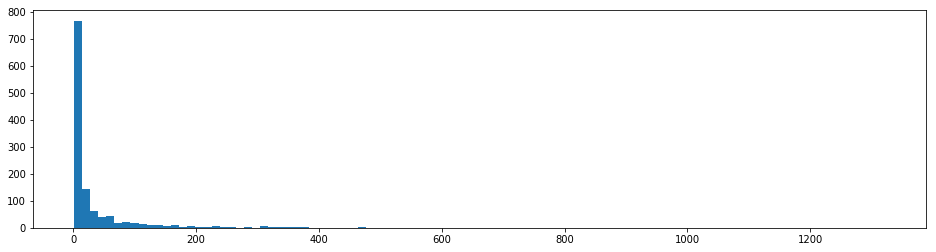

In [879]:
print(np.mean(np.array(list(dic2.values()))))
plt.figure(figsize=(16,4))
plt.hist(list(dic2.values()), bins=100)
plt.show()

In [880]:
########################## CAR MODEL BALANCING ##########################
l = len(data)
mean = np.mean(np.array(list(dic2.values()))) * 10
mask = np.ones(l, dtype=bool)
for j in range(l):
    if dic2[data['model'][j]] > 2 * mean:
        mask[j] = random() > 0.60
    elif dic2[data['model'][j]] > 1.4:
        mask[j] = random() > 0.45
len(mask), mask.sum()

(52651, 28332)

In [881]:
data = data[mask]
data = data.reset_index(drop=True)

In [886]:
############################## STEERING WHEEL BALANCING ##############################
l2 = len(data)
mask2 = np.ones(l2, dtype=bool)
for j in range(l2):
    if data['wheel'][j] == 'левый':
        mask2[j] = random() > 0.5
#     elif dic2[data['model'][j]] > 1.4:
#         mask[j] = random() > 0.55
len(mask2), mask2.sum()

(28332, 19284)

In [887]:
data = data[mask2]
data = data.reset_index(drop=True)

#### ----------------------------- BEST -----------------------------

In [130]:
### Filter texts by lower length limit
def filterb(data, n = 100):
    return data[data['descr'].map(len) > n]

In [131]:
### Filter texts by higher length limit (low-pass)
def filter_low(data, n = 800):
    return data[data['descr'].map(len) > n]

In [ ]:
best = filterb(data, 100)
lb = len(best)
lb

In [ ]:
# best = filter_low(best, 800)
# lb = len(best)
# lb

In [806]:
best = df_clean(best)

In [893]:
lns = []
for i in range(lb):
    lns.append(len('; '.join(best.iloc[i, 3:-1])))

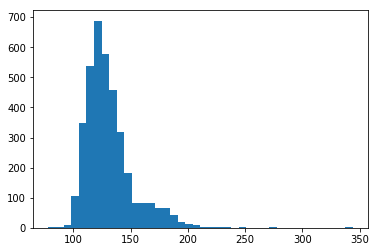

In [894]:
plt.hist(lns, bins=40)
plt.show()

#### ------------------ DATA LOADING

In [442]:
#dat = pd.read_pickle('dataf0.pkl', compression='gzip')
da = pd.read_pickle('./data_1125044.pkl', compression='gzip')
#da =pd.read_pickle('./data_1111044.pkl', compression='gzip')

In [3]:
data = pd.read_pickle('./data_1360044.pkl', compression='gzip')

In [427]:
da1 = data[18326:52651]

In [2566]:
vc0 = data['descr'].apply(lambda x: x[:16]).value_counts()
dict(vc0[50:100])

In [2591]:
# data = data[data['descr'].apply(lambda x: map_reg(x, regs))]
# #data.reset_index(dr)
# len(data)

47049

In [ ]:
data.shape#, da5.shape

#### -------------------------------- messing around ------------------------------------------------

In [6]:
#data = df_clean(data)
data = df_clean(data, False)

In [7]:
data.drop(columns = ['head', 'price', 'engine', 'power', 'gears', 'drive', 'body',
                           'color', 'mile', 'wheel', 'notes',  'gen', 'trim', 'exch'], inplace = True)

In [435]:
#len(data) # = 134514
for i in range(134514) :
    el = data.iloc[i]
    res = re.search('''\^''', el['descr'])
    if res:
        print('''>>>''', el['num'], el['descr'][res.start() - 10 : res.end()+20])

>>> 41200459 се деньги ^)
>>> 41201165 смартфона)^ - произведена тонир
>>> 41234633 мятинок , ^подсказываю^ он в ав
>>> 41243999 е диски 18^, рейлинги серебрист
>>> 41247189 ПЛЕКТАЦИЯ ^ Кондиционер. Подогр


In [290]:
da2.to_pickle('./data_1220044.pkl', compression='gzip')

In [ ]:
matches = []
with open('stopword.txt', 'r', encoding='utf-8') as f:
    for ln in f:
        matches.append(ln.rstrip())
matches

In [38]:
regs = [re.compile(el) for el in matches]

In [40]:
def filter_reg(data, regs):
    l0 = len(data)
    reg_idx = np.ones(l0, dtype=bool)
    for i in tqdm(range(l0)):
        for rr in regs:
            if re.match(rr, data.iloc[i, -1]): ######################## <<<<<<<<!!!!!!!!!!!!
                reg_idx[i] = False
                break
    return reg_idx

In [148]:
def filter_reg_(data, regs):
    l0 = len(data)
    reg_idx = np.ones(l0, dtype=bool)
    for i in tqdm(range(l0)):
        for rr in regs:
            if re.match(rr, data.iloc[i, -2]):
                reg_idx[i] = False
                if rr.pattern in regs_used:
                    regs_used[rr.pattern] += 1
                else:
                    regs_used[rr.pattern] = 1
                    #print('added: '+ rr.pattern)
                break
    return reg_idx

In [41]:
def map_reg(st, regs):
    for rr in regs:
        if re.match(rr, st):
            return False
    return True

In [ ]:
#da2 = df_clean(da2)

In [463]:
#dat = df_clean(dat, False)

In [ ]:
#data[data['descr'].apply(len)<100][:40]
data[data['card'].apply(len)>10][:40]

In [ ]:
plt.figure(figsize=(16, 4))
plt.hist(data['descr'].apply(len), bins=100, range=(0, 2000))
plt.grid(True)
plt.show()

In [ ]:
#########################################################################################

In [14]:

dic1, dic2 = make_mod(data)

In [331]:
mdls = pd.Series(dic2)
mdls.groupby(mdls.values).count()

In [ ]:
dic2

In [16]:
#l = len(data0)
mean = np.mean(np.array(list(dic2.values()))) * 10
mean

186.80937818552496

In [21]:
ids_more = data[data['model'].apply(lambda x: dic2[x]>mean)].index
ids_less = data[data['model'].apply(lambda x: dic2[x] <= mean)].index

len(ids_more), len(ids_less)

In [22]:
dlens0 = data.loc[ids_more, 'descr'].apply(len)
dlens_ =  data.loc[ids_less, 'descr'].apply(len)

In [24]:
ids_comb = (dlens_ > 300).append(dlens0 > 500 ) 
ids_comb.sum()

In [25]:
(dlens_ > 300).sum(), (dlens0 > 500 ) .sum(), ids_comb.sum()

(7171, 1203, 8374)

In [ ]:
#####################################################################################

In [76]:
best = data[ids_comb]#.sort_index()

In [ ]:
data[idscomp].iloc[110, -2]

In [135]:
best = filterb(data, 100)

In [144]:
len(best)# , decide(''), 

65258

In [ ]:
data[data['descr'].apply(lambda x: x[:8]) == 'Возможна']#[100:]

In [145]:
best = best[best['card'].apply(decide)]
len(best)

45616

In [149]:
regs_used = dict()
ids_regs = filter_reg_(best, regs)

100%|███████████████████████████████████████████████████████████████████████████| 45616/45616 [03:50<00:00, 197.82it/s]


In [ ]:
sorted([(k, v) for k, v in regs_used.items()],key = lambda x: x[1], reverse=True)

In [ ]:
#best[best['descr'].apply(lambda x: x[:1]) == '"'][40:]#[100:]
best[(best['descr'].apply(lambda x: x[:4]) == 'Ауди') & (best['card'].apply(decide))]#[100:]

In [ ]:
## Unfiltered during card filter; real names
best[best['card'].apply(lambda x: bool(x))]

In [51]:
best.drop(columns = 'card', inplace = True)

In [2654]:
######################################################################## model balancing
mask = np.ones(l, dtype=bool)
for j in range(l):
    if dic2[data0['model'][j]] > 2 * mean:
        mask[j] = random() > 0.60
    elif dic2[data0['model'][j]] > 1.4:
        mask[j] = random() > 0.45
len(mask), mask.sum()

(59848, 32177)

In [ ]:
plt.figure(figsize=(16, 4))
#plt.hist( [len(x[2]) for x in cards ] , bins = 99, range=(1, 100))
plt.hist( dlens_ , bins = 100, color = 'y')
plt.hist( dlens0 , bins = 100)

#plt.ylim((0, 300))
#plt.xlim((0, 50))
plt.grid(True)
plt.plot()
#max([len(x[2]) for x in cards ])

#### ------------------- WRITE TO FILE

In [53]:
def writetof(data, filen, n = None,):
    if not n:
        n = len(data)
    assert n <= len(data), 'too much ns'
    with open(filen, 'w', encoding = 'utf-8') as f:
        for i in range(n):
            f.writelines('; '.join(data.iloc[i, 3:]) + '\n')

In [54]:
writetof(best, 'tx4_3h5h.txt')

In [29]:
def filestat(filen, enc = None):
    with open(filen, 'r', encoding=enc
             ) as f:
        lens = [len(s) for s in f]
        return sum(lens), len(lens), sum(lens)/ len(lens)

In [30]:
def filest(filen, enc = None):
    with open(filen, 'r', encoding=enc) as f:
        lens = [len(s) for s in f]
        return lens

In [2661]:
filestat('tx4_200.txt', enc='utf-8')

(6069573, 10171, 596.7528266640448)

######################################################################################################

In [492]:
############################################################################################
################################################# NAMES ############################################
with open('gen_0.txt', 'r', encoding='utf-8') as f:
    names = f.readline().rstrip().split(', ')
', '.join(names)

'Антон, Юра, Дима, Вадим, Алексе, паша, Андрей, сергей, макс\\S?\\S?, василий, александр, роман, игорь, денис, евгений, Владислав, Никита, дмитрий, олег, павел, Михаил, Иван, вячеслав, Семен, арт\\Sм, Елизавета, Константин, александр, Виталий, Ирина, Вадим, Валерий, Виктор, Илья, Анна, Кристина, Василий, Михаил, наталья, dealer103116, dealer49762'

In [32]:
def check_reg(st, regs, case=True):
    for rr in regs:
        if case:
            if re.match(re.compile(rr, re.IGNORECASE), st):
                return True
        else:
            if re.match(re.compile(rr), st):
                return True
    return False

In [33]:
def decide(name):
    if name:
        if len(name) < 11:
            return check_reg(name, names)
        else:
            return False
    else:
        return True

#######################################################################################################################
